In [1]:
import numpy as np
from pykalman import KalmanFilter

In [2]:
from utils import *

In [149]:
def get_projected_celerity_profiles2(PROFS, step):
    projected_profiles = []
    for prof in PROFS:
        domain = np.arange(int(prof.depth[-1])+1, int(prof.depth[0]), step)
        p = prof.get_sound_speed(domain)
        projected_profiles.append(p)
    return projected_profiles

In [152]:
Im = 1
H = np.array([[1,0,0]])
std_mes = 0.1
std_dyn = 10**-4
TM = np.array([[1, Im, Im**2/2],
        [0, 1, Im],
        [0, 0, 1]])

In [153]:
Q = std_dyn ** 2 * np.array([[Im ** 6 / 20, Im ** 5 / 8, Im ** 4 / 6],
                                       [Im ** 5 / 8, Im ** 4 / 3, Im ** 3 / 2],
                                       [Im ** 4 / 6, Im ** 3 / 2, Im ** 2]])

The domain goes from depth 50 m to 999 m.
The number of profiles that can be projected on the domain is 16730.


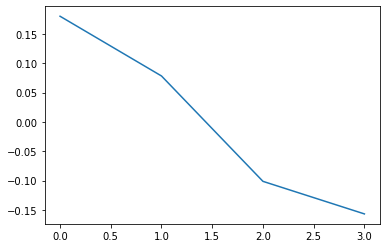

In [154]:
print(f"The domain goes from depth {domain[0]} m to {domain[-1]} m.")
PROFS = get_all_profiles()
projected_PROFS = get_projected_celerity_profiles2(PROFS, Im)
print(f"The number of profiles that can be projected on the domain is {len(projected_PROFS)}.")
suppress_nans_celerities(projected_PROFS)
y = projected_PROFS[0].celerities
y_avg = y-np.mean(y)
plt.plot(y_avg)

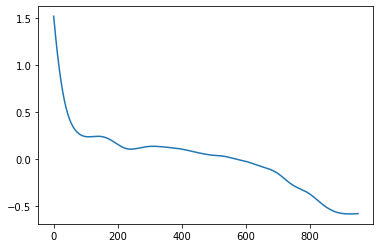

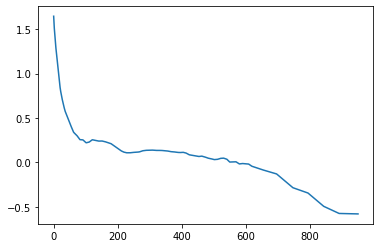

In [129]:
KF_true_Q_R=KalmanFilter(transition_matrices = TM, observation_matrices = H,
                          
                         transition_covariance = Q, observation_covariance = [[std_mes]])
a, b = KF_true_Q_R.smooth(y_avg)

smoothed = a[:, 0]
plt.plot(smoothed)
plt.show()
plt.plot(y_avg)
plt.show()

In [130]:
def detect_local_extrema(profile, domain):
    local_maxs = []
    local_mins = []
    previous_diff = profile[1] - profile[0]
    for i in range(1, len(profile)-1):
        diff = profile[i+1] - profile[i]
        if diff > 0 and previous_diff < 0:
            local_mins.append(domain[i])
        if diff < 0 and previous_diff > 0:
            local_maxs.append(domain[i])
        previous_diff = diff
    return local_mins, local_maxs

local_mins, local_maxs = detect_local_extrema(smoothed, domain)
print(local_mins)
print(local_maxs)
        
    
    
    

[159, 291, 974]
[187, 360]
